In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [15]:
df = pd.read_csv("data/train.csv")
df.head()


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

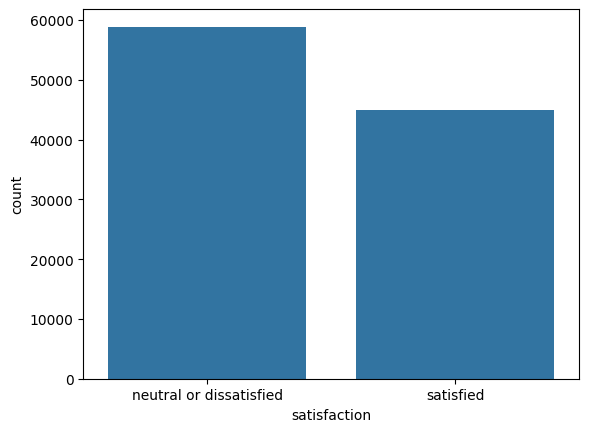

In [16]:
df.info()
df.describe()
df.isnull().sum()
sns.countplot(x=df["satisfaction"])
plt.show()


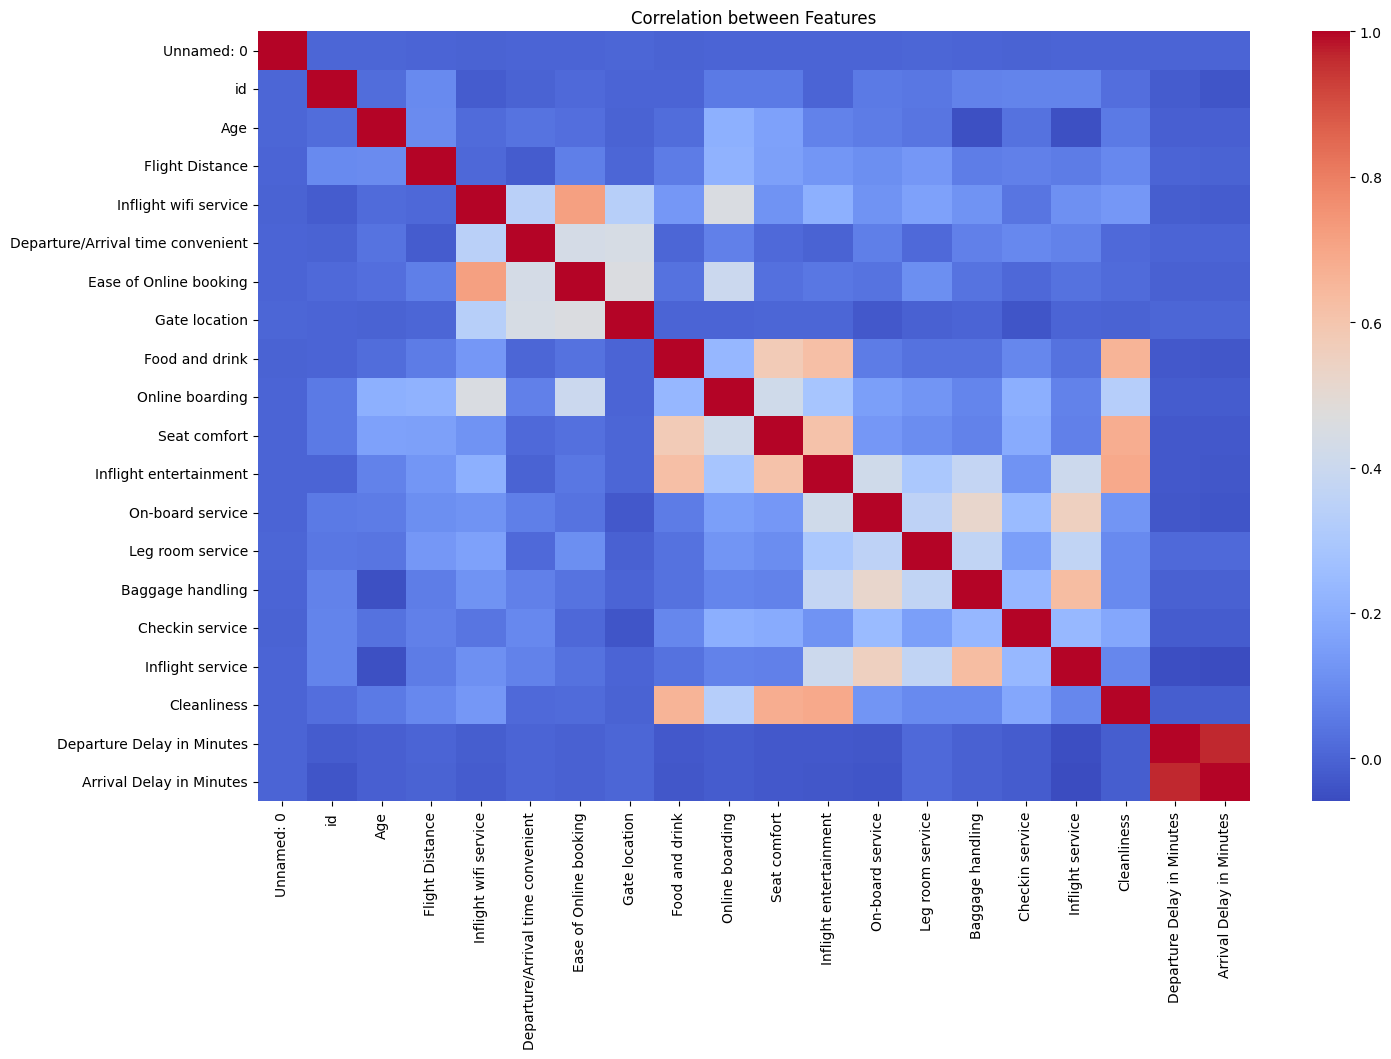

In [17]:
plt.figure(figsize=(16, 10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation between Features")
plt.show()


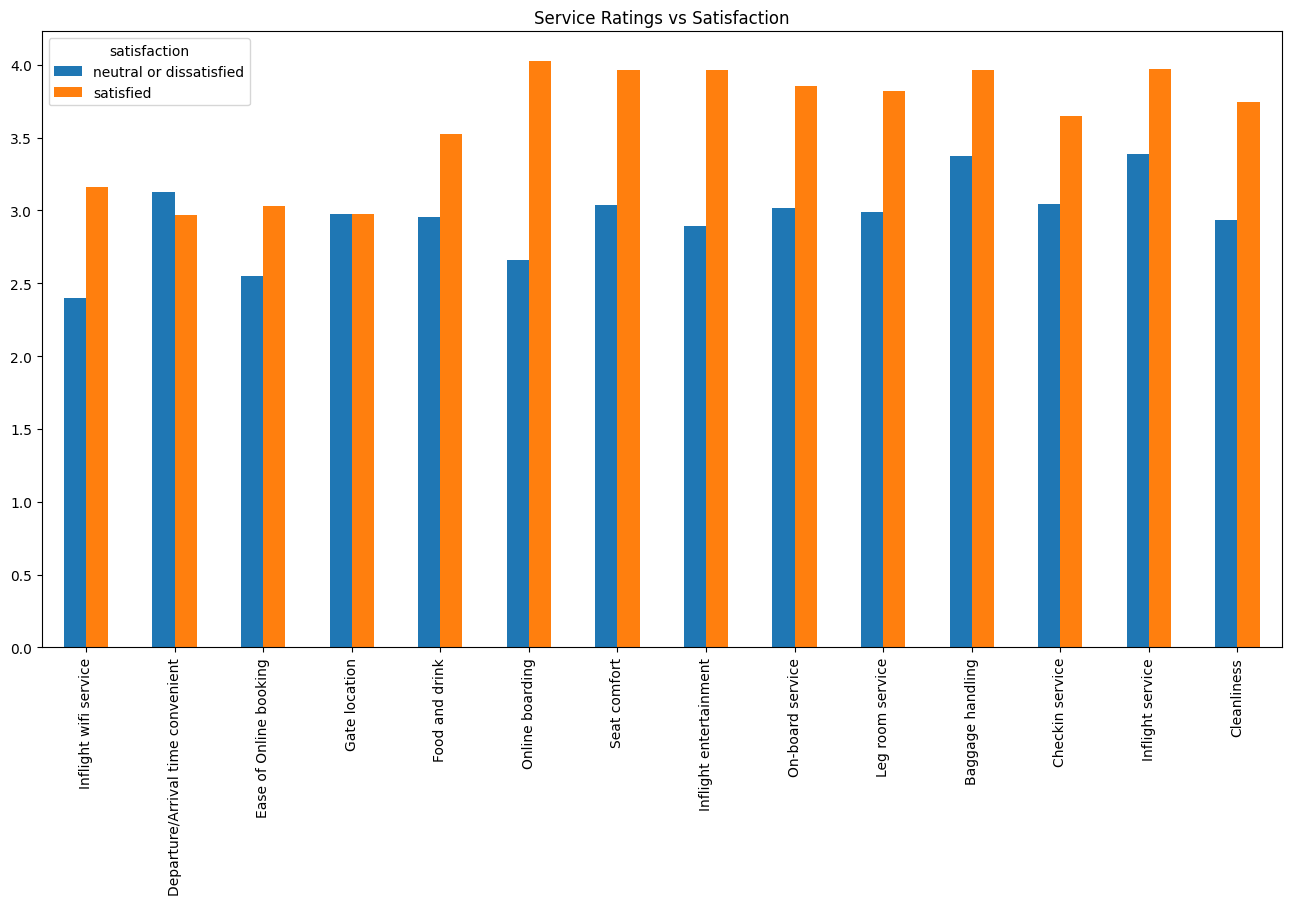

In [18]:
service_cols = [
    'Inflight wifi service','Departure/Arrival time convenient','Ease of Online booking',
    'Gate location','Food and drink','Online boarding','Seat comfort','Inflight entertainment',
    'On-board service','Leg room service','Baggage handling','Checkin service',
    'Inflight service','Cleanliness'
]

df.groupby('satisfaction')[service_cols].mean().T.plot(kind='bar', figsize=(16,8))
plt.title("Service Ratings vs Satisfaction")
plt.show()


In [19]:
# Encode categorical features
cat_cols = X.select_dtypes(include=['object']).columns

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Handle missing values
# 1. Fill categorical NaN using mode
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# 2. Fill numeric NaN using median
num_cols = X.select_dtypes(include=[np.number]).columns
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

# Train-test split BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [20]:
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))


Logistic Regression Accuracy: 0.8788316250421058
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     11713
           1       0.88      0.84      0.86      9068

    accuracy                           0.88     20781
   macro avg       0.88      0.87      0.88     20781
weighted avg       0.88      0.88      0.88     20781



In [21]:
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))


XGBoost Accuracy: 0.9625138347528993
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11713
           1       0.97      0.94      0.96      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781



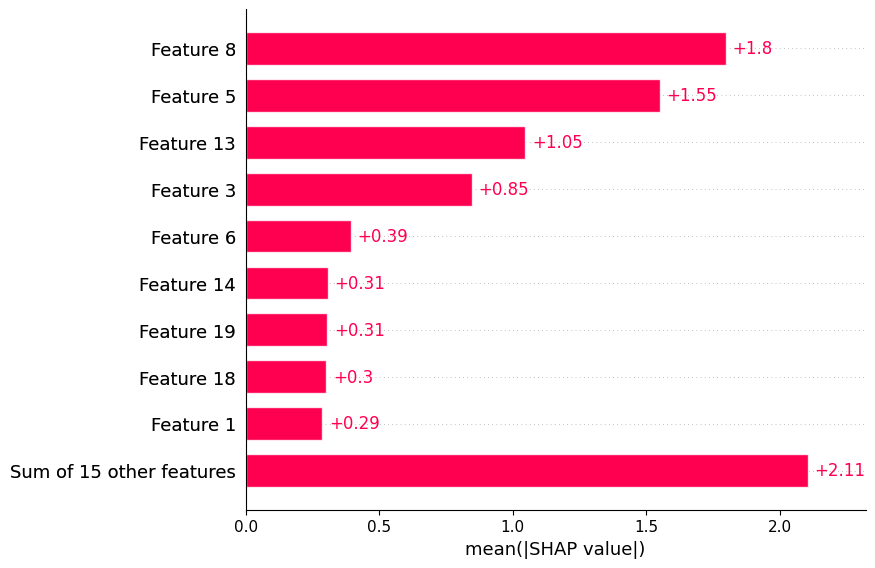

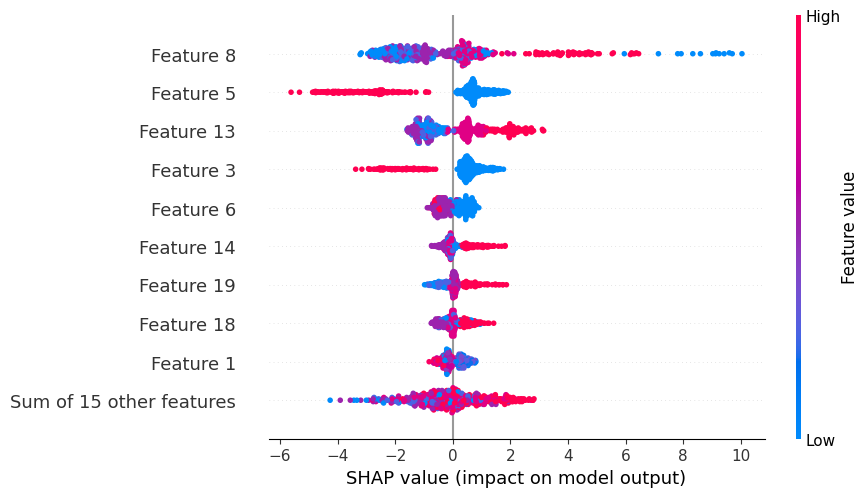

In [22]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test[:500])

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)


In [23]:
import os
os.makedirs("models", exist_ok=True)
with open("model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
